# Experimental Design with PlanOut

### Outline
- A simple A/B test
- How PlanOut works
- Recipes:
  - Factorial designs
  - Cluster-randomized experiments
  - Experiments with multiple units

### Loading up PlanOut
This imports basic operators for doing random assignment and `SimpleExperiment`, the base class for logging

In [8]:
%pylab inline
from planout.ops.random import *
from planout.experiment import SimpleExperiment
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Anatomy of a simple A/B test

- Define new experiments by subclassing `SimpleExperiment`
- Implement logic in `assign()` method.
- Use `params` object to perform random assignments

In [9]:
class VotingExperiment(SimpleExperiment):
  def assign(self, params, userid):
    params.button_text = UniformChoice(
      choices=["I'm a voter", "I'm voting"],
      unit=userid
    )

### Using PlanOut
Get randomized assignments for input units by creating instances of the class.

In [10]:
e = VotingExperiment(userid=212)
print e.get('button_text')

I'm a voter


### Using PlanOut
Here are the assignments for 10 userids.

In [11]:
for i in xrange(10):
    e = VotingExperiment(userid=i)
    print "user %s sees: %s" % (i, e.get('button_text'))

user 0 sees: I'm voting
user 1 sees: I'm voting
user 2 sees: I'm voting
user 3 sees: I'm a voter
user 4 sees: I'm voting
user 5 sees: I'm a voter
user 6 sees: I'm voting
user 7 sees: I'm a voter
user 8 sees: I'm voting
user 9 sees: I'm voting


To check to see that the experiment is doing what we expect it to, we can simulate assignments for many userids and construct a dataframe with all of the assignments:

In [12]:
e.get_params()

{'button_text': "I'm voting"}

In [13]:
sim_users = [VotingExperiment(userid=i).get_params() for i in xrange(10000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['button_text']).size()

button_text
I'm a voter    5000
I'm voting     5000
dtype: int64


# How random assignment works in PlanOut

* PlanOut uses deterministic hashing to perform random assignments
* Unless otherwise specified, all random assignments are independent.
* Ensures that:
  * The same units (e.g., user ids) get mapped to different values for different experiments or parameters.
  * Assignments are as good as random.

### Underneath the hood

PlanOut computes a hash that looks like:

```
  f(SHA1(experiment_name.parameter_name.unit_id))
```
So that:

In [14]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid)
    params.y = UniformChoice(choices=['a','b'], unit=userid)

uses a hash like:
```
  SHA1(RandomExample1.x.4) % 2
```
  
to select the value for `x` when the given `userid` is 4.

### Parameter-level salts

In [15]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid)
    params.y = UniformChoice(choices=['a','b'], unit=userid)
    
sim_users = [RandomExample1(userid=i).get_params() for i in xrange(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['x', 'y']).size()

x  y
0  a    531
   b    475
1  a    478
   b    516
dtype: int64


### Automatic salting

PlanOut implicitly uses parameter name as salt:

In [16]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid, salt='x')
    params.y = UniformChoice(choices=['a','b'], unit=userid, salt='y')
    
sim_users = [RandomExample1(userid=i).get_params() for i in xrange(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['x', 'y']).size()

x  y
0  a    531
   b    475
1  a    478
   b    516
dtype: int64


### Changing the salts change the assignments:

In [17]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid, salt='x2')
    params.y = UniformChoice(choices=['a','b'], unit=userid, salt='y2')
    
sim_users = [RandomExample1(userid=i).get_params() for i in xrange(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['x', 'y']).size()

x  y
0  a    507
   b    493
1  a    506
   b    494
dtype: int64


### Correlated assignments
- Parameters with the same salt will have correlated assignments.

In [18]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid, salt='x')
    params.y = UniformChoice(choices=['a','b'], unit=userid, salt='x')
    
sim_users = [RandomExample1(userid=i).get_params() for i in xrange(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['x', 'y']).size()

x  y
0  a    1006
1  b     994
dtype: int64


### Experiment-level salts

- Using experiment name in salt ensures indepence between experiments
- By default, experiment class names are used as experiment-level salts

In [19]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid)
    params.y = UniformChoice(choices=['a','b'], unit=userid)
    
class RandomExample2(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[4, 8], unit=userid)
    params.y = UniformChoice(choices=['m','n'], unit=userid)

sim_users = [RandomExample1(userid=i).get_params() for i in xrange(4000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['x', 'y']).size()

sim_users = [RandomExample2(userid=i).get_params() for i in xrange(4000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['x', 'y']).size()

x  y
0  a    1009
   b     962
1  a    1004
   b    1025
dtype: int64
x  y
4  m    1017
   n     979
8  m    1026
   n     978
dtype: int64


### Custom experiment-level salts

In [20]:
class RandomExample1(SimpleExperiment):
  def setup(self):
        self.salt = 'RandomExample2'

  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid)
    params.y = UniformChoice(choices=['a','b'], unit=userid)

sim_users = [RandomExample2(userid=i).get_params() for i in xrange(4000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['x', 'y']).agg(len)


x  y
4  m    1017
   n     979
8  m    1026
   n     978
dtype: int64


### Random assignment with multiple units

- When multiple units are used, units are concatinated,
- e.g., if `userid=4` and `url='http://news.ycombinator.com'`, the hash would be:

```
    f(SHA1('RandomExperiment1.show_thumbnail.6.http://news.ycombinator.com'))
```

In [21]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid, url):
    params.show_thumbnail = BernoulliTrial(p=0.15, unit=[userid, url])

RandomExample1(userid=6, url='http://news.ycombinator.com').get('show_thumbnail')

0

### Order matters

In [22]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid, url):
    params.show_thumbnail = BernoulliTrial(p=0.15, unit=[url, userid])

RandomExample1(userid=6, url='http://news.ycombinator.com').get('show_thumbnail')

1

# Recipes for experimental designs

## Factorial designs

Parameter assignments (by default) are performed independently, so a 2x2 design can be constructed simply by setting another parameter.

In [23]:
class VotingExperiment(SimpleExperiment):
  def assign(self, params, userid):
    params.button_text = UniformChoice(
      choices=["I'm a voter", "I'm voting"],
      unit=userid
    )
    params.has_social_cues = UniformChoice(
      choices=[1, 0],
      unit=userid
    )

#### A few examples of assignments produced by the data...

In [24]:
sim_users = [VotingExperiment(userid=i).get_params() for i in xrange(10000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments[:5]

   button_text  has_social_cues
0   I'm voting                1
1   I'm voting                0
2   I'm voting                1
3  I'm a voter                0
4   I'm voting                1


#### Crosstabs: 

In [25]:
print assignments.groupby(['button_text', 'has_social_cues']).size()

button_text  has_social_cues
I'm a voter  0                  2485
             1                  2515
I'm voting   0                  2447
             1                  2553
dtype: int64


### Unequal probability assignment with WeightedChoice

The `WeightedChoice` operator lets you select choices with different probabilities.

In [26]:
class VotingExperiment(SimpleExperiment):
  def assign(self, params, userid):
    params.button_text = UniformChoice(
      choices=["I'm a voter", "I'm voting"],
      unit=userid
    )
    params.has_social_cues = WeightedChoice(
      choices=[1, 0],
      weights=[8, 2],
      unit=userid
    )

#### Crosstabs

In [27]:
sim_users = [VotingExperiment(userid=i).get_params() for i in xrange(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['button_text', 'has_social_cues']).size()

button_text  has_social_cues
I'm a voter  0                  192
             1                  797
I'm voting   0                  196
             1                  815
dtype: int64


## Arbitrary cell probabilites in a factorial design

Consider the case where there are organizational factors that limit the size of your experiment. For example, if in a hypothetical get out the vote experiment at Facebook only 5% of the users could be used as part of an experiment used to evaluate the effects of various encouragements to vote.

Because of this, the experimenters decided they wanted to assign users with a matrix of probabilities like:

$$ \left[
  \begin{array}{ l c c }
     & \text{has megaphone} & \text{no megaphone} \\
     \text{has feed} & 0.95 & 0.015 \\
     \text{no feed} & 0.02 & 0.015
  \end{array} \right]$$
  
There are multiple ways to do this.

#### Method 1: Conditional probabilities

Method 1 first assigns users to see or not see the megaphone with probability 0.97. Half of those 3% are then assigned to see feed stories about voting, while 98% of those who see megaphones are assigned to the see the stories. This produces the assignment probabilities given about.

In [28]:
class VotingExperiment(SimpleExperiment):
  def assign(self, params, userid):
    params.has_megaphone = BernoulliTrial(
      p=0.97,
      unit=userid
    )
    cond_probs = [0.5, 0.98]
    params.has_feed = BernoulliTrial(
      p=cond_probs[params.has_megaphone],
      unit=userid
    )

In [29]:
sim_users = [VotingExperiment(userid=i).get_params() for i in xrange(10000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['has_feed', 'has_megaphone']).size()

has_feed  has_megaphone
0         0                 147
          1                 198
1         0                 142
          1                9513
dtype: int64


#### Method 2: Binary encoding of cell positions

Method 2 selects the four conditions with their respective probabilities from a flat list. It then picks out elements of an array corresponding to the cell positions. For a very small number of subjects, this method will produce slightly more imbalance, but for larger N it will acheive similar levels of balance compared to method 1.

In [30]:
class VotingExperiment(SimpleExperiment):
  def assign(self, params, userid):
    params.idx = WeightedChoice(
      choices=[0, 1, 2, 3],
      weights=[0.95, 0.02, 0.015, 0.015],
      unit=userid
    )
    params.has_megaphone = [1,1,0,0][params.idx]
    params.has_feed = [1,0,1,0][params.idx]

#### Crosstabs

In [31]:
sim_users = [VotingExperiment(userid=i).get_params() for i in xrange(10000)]
assignments = pd.DataFrame.from_dict(sim_users)
print assignments.groupby(['has_feed', 'has_megaphone']).size()

has_feed  has_megaphone
0         0                 156
          1                 209
1         0                 147
          1                9488
dtype: int64


## More than two factor levels

Small changes in appearance can have significant effects on individual behavior. Google is infamous for testing [41 different shades of blue](http://www.nytimes.com/2009/03/01/business/01marissa.html) for their link colors. Let's implement that experiment.

In [32]:
class ColorExperiment(SimpleExperiment):
  def assign(self, params, userid):
    params.blue_value = RandomInteger(
        min=215,
        max=255,
        unit=userid
    )
    params.link_color = '#0000%s' % format(params.blue_value, '02x')

In [33]:
ColorExperiment(userid=10).get_params()

{'blue_value': 247, 'link_color': '#0000f7'}

#### Sample data

In [34]:
sim_users = [ColorExperiment(userid=i).get_params() for i in xrange(20000)]
assignments = pd.DataFrame.from_dict(sim_users)

In [35]:
assignments[:5]

,blue_value,link_color
0,231,#0000e7
1,248,#0000f8
2,242,#0000f2
3,230,#0000e6
4,239,#0000ef


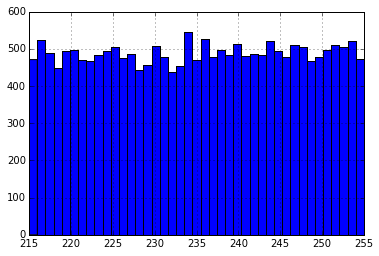

In [36]:
assignments['blue_value'].hist(bins=41);

## Within-subjects designs (simple random assignment)

In some cases you might want to assign user-item pairs or user-session pairs to parameters. You can do this by simply passing more units into `assign()` and applying multiple units.

In [37]:
class SelectiveExposureExperiment(SimpleExperiment):
  def assign(self, params, subjectid, url):
    params.has_source_cues = BernoulliTrial(p=0.5, unit=subjectid)
    params.has_social_cues = BernoulliTrial(p=0.5, unit=subjectid)
    
    if params.has_source_cues:
      sources = ['Fox News','USA Today', 'CNN', 'MSNBC']
      params.source = UniformChoice(
        choices=sources,
        unit=[subjectid, url]
      )

## Within-subjects designs (balanced random assignment)

If there are a small number of URLs in the case above, it is sometimes possible to not select a particular source, or disproportionately select one source. If a complete list of URLs is known in advance, it is possible to acheive complete balance by permuting a pre-constructed list of sources containing an exactly balanced list. The following code cycles through all sources, so that e.g., if there are 6 URLs, each source appears exactly twice. It also shuffles the URLs (in a deterministic fashion).

In [38]:
from itertools import cycle, islice

class SelectiveExposureExperiment(SimpleExperiment):
  def assign(self, params, subjectid, urls): 
    params.shuffled_urls = Sample(choices=urls, unit=subjectid)
    
    params.has_source_cues = BernoulliTrial(p=0.5, unit=subjectid)
    params.has_social_cues = BernoulliTrial(p=0.5, unit=subjectid)
    
    if params.has_source_cues:
      balanced_sources = list(islice(cycle(['Fox News','USA Today', 'CNN', 'MSNBC']), len(urls)))
      params.shuffled_sources = Sample(choices=balanced_sources, unit=subjectid)

In [39]:
ex_urls = ['http://reuters.com/article%s.html' % i for i in xrange(8)]

subject = 18
e = SelectiveExposureExperiment(subjectid=subject, urls=ex_urls)
pd.DataFrame.from_dict(e.get_params())

,has_social_cues,has_source_cues,shuffled_urls
0,0,0,http://reuters.com/article0.html
1,0,0,http://reuters.com/article7.html
2,0,0,http://reuters.com/article2.html
3,0,0,http://reuters.com/article6.html
4,0,0,http://reuters.com/article4.html
5,0,0,http://reuters.com/article1.html
6,0,0,http://reuters.com/article5.html
7,0,0,http://reuters.com/article3.html


## Clustered randomized assignment

Random assignment can also occur at the cluster level. For example, a course on MOOCs might randomize classes into treatment conditions.  Here, course ID, rather than the student ID, is used for random assignment. Note that while the student ID is not actually used for random assignment, it is still useful to pass it in to the experiment object for logging purposes.

In [40]:
class BadgeExperiment(SimpleExperiment):
  def assign(self, params, studentid, courseid):
    params.has_faces = BernoulliTrial(p=0.8, unit=courseid)

## Stepped-wedge design

Stepped wedge designs expose subjects or clusters of subjects to treatments at a certain random point in time. This can improve precision when there are time-correlated exogenous events that may affect subjects' behaviors, or when there are constraints on how rapidly you can roll out treatments.

In [41]:
class BadgeExperiment(SimpleExperiment):
  def assign(self, params, studentid, courseid, week):
    params.rollout_week = RandomInteger(
      min=0,
      max=8,
      unit=courseid
    )
    if week >= params.rollout_week:
      params.has_faces = 1
    else:
      params.has_faces = 0

#### Demo of time-based rollout

In [42]:
example_course = 17
e = BadgeExperiment(studentid=2, courseid=example_course, week=0)
rollout_week = e.get('rollout_week')
print 'The badge rollout for course %s is %s...' % (example_course, rollout_week)

for week in xrange(9):
  exp = BadgeExperiment(studentid=2, courseid=example_course, week=week)
  print 'week %s: has_faces = %s ' % (week, exp.get('has_faces'))

The badge rollout for course 17 is 2...
week 0: has_faces = 0 
week 1: has_faces = 0 
week 2: has_faces = 1 
week 3: has_faces = 1 
week 4: has_faces = 1 
week 5: has_faces = 1 
week 6: has_faces = 1 
week 7: has_faces = 1 
week 8: has_faces = 1 


## Social cues experiment

Let's consider a social cues experiment where an individual has a certain number of friends that we might show in association with a page, and we want to deterministically randomly sample from some subset of those friends. This is the setup from [Social Influence in Social Advertising: Evidence from Field Experiments](http://arxiv.org/pdf/1206.4327.pdf).

In [43]:
class CueExperiment(SimpleExperiment):
  def assign(self, params, userid, page, friends):
    params.num_friends_shown = RandomInteger(
      min=0,
      max=min(3, len(friends)),
      unit=[userid, page]
    )
    params.friends_shown = Sample(
      choices=friends,
      draws=params.num_friends_shown,
      unit=[userid, page]
    )

In [44]:
some_friends = ["Sean", "Cat", "Solomon", "Dean", "Annie", "Moira", "Ronald", "Mike"]

for pid in xrange(12):
    print CueExperiment(userid=6, page=pid, friends=some_friends).get('friends_shown')

['Dean', 'Solomon']
[]
['Ronald', 'Annie', 'Moira']
['Solomon', 'Ronald', 'Mike']
['Mike']
['Sean', 'Cat']
['Mike']
[]
['Mike', 'Ronald', 'Solomon']
['Solomon', 'Cat', 'Ronald']
['Sean', 'Dean', 'Mike']
['Moira', 'Mike', 'Solomon']


## More complex between subjects experiment

- How does feedback affect content production?
- Use experiments to modulate feedback a focal subject receives by varying encouragements for peers to provide feedback.

In [45]:
class ContentExperiment(SimpleExperiment):
  def assign(self, params, producerid, storyid, viewerid):
    params.p = RandomFloat(
        min=0,
        max=1,
        unit=producerid
    )
    params.collapse = BernoulliTrial(
        p=params.p,
        unit=[storyid, viewerid]
    )

Each user has some overall probability that viewers of their story will see an expanded version of their post. Expanded versions receive more feedback. Subjects are assigned some proportion of impressions of their stories to be expanded. The `expand` parameter is assigned using both the post and the viewer, so that different posts and different viewers may see the story epxnaded some times but not others.

In [46]:
def sim_impressions(producerid, storyid):
    viewers = range(5)
    sim_users = [ContentExperiment(producerid=producerid, storyid=storyid, viewerid=viewerid).get_params() for viewerid in viewers]
    df = pd.DataFrame.from_dict(sim_users)
    df['producerid'] = producerid
    df['storyid'] = storyid
    df['viewerid'] = viewers
    return df

### With a few different producers...

In [47]:
sim_impressions(producerid=10, storyid=2)

,collapse,p,producerid,storyid,viewerid
0,0,0.04197,10,2,0
1,0,0.04197,10,2,1
2,0,0.04197,10,2,2
3,0,0.04197,10,2,3
4,0,0.04197,10,2,4


### With a few different producers...

In [48]:
sim_impressions(producerid=17, storyid=2)

,collapse,p,producerid,storyid,viewerid
0,0,0.155989,17,2,0
1,0,0.155989,17,2,1
2,0,0.155989,17,2,2
3,1,0.155989,17,2,3
4,0,0.155989,17,2,4


### With different stories...

In [49]:
sim_impressions(producerid=17, storyid=4)

,collapse,p,producerid,storyid,viewerid
0,0,0.155989,17,4,0
1,0,0.155989,17,4,1
2,0,0.155989,17,4,2
3,0,0.155989,17,4,3
4,0,0.155989,17,4,4


### With different stories

In [50]:
sim_impressions(producerid=17, storyid=15)

,collapse,p,producerid,storyid,viewerid
0,1,0.155989,17,15,0
1,1,0.155989,17,15,1
2,0,0.155989,17,15,2
3,0,0.155989,17,15,3
4,1,0.155989,17,15,4


### Different units identify different effects: Like hearding

Assigning p based on `storyid` lets you study like hearding

In [51]:
class ContentExperiment(SimpleExperiment):
  def assign(self, params, producerid, storyid, viewerid):
    params.p = RandomFloat(
        min=0,
        max=1,
        unit=storyid
    )
    params.expand = BernoulliTrial(
        p=params.p,
        unit=[storyid, viewerid]
    )

### Different units identify different effects: Reciprocity

Assigning p based on [viewerid, producerid] pairs lets you study reciprocity

In [52]:
class ContentExperiment(SimpleExperiment):
  def assign(self, params, producerid, storyid, viewerid):
    params.p = RandomFloat(
        min=0,
        max=1,
        unit=[viewerid, producerid]
    )
    params.expand = BernoulliTrial(
        p=params.p,
        unit=[storyid, viewerid]
    )

In [53]:
print(ContentExperiment(producerid=15, viewerid=10, storyid=5).get_params())
print(ContentExperiment(producerid=10, viewerid=15, storyid=5).get_params())

{'p': 0.4080478355600889, 'expand': 0}
{'p': 0.2496919900519681, 'expand': 0}


### Exercise: How can you encourage dyads in both directions direction?

- Create an experiment called ContentExperiment2 where the same p is assigned to pairs of users no matter who the viewer is
- One possible solution will produce assignments that looks like:

print(ContentExperiment2(producerid=15, viewerid=10, storyid=5).get_params())
print(ContentExperiment2(producerid=10, viewerid=15, storyid=5).get_params())

### Exercise: Design the selective exposure experiment in PlanOut
- Show 3 stories from a set of 10 stories (assume stories are in a list)
- Randomly assign each story to a source cue, Fox News, MSNBC, or CNN
- Stories should be able to be any any of the 3 positions, and source cues should appear in any of the 3 positions